In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

from tqdm.auto import tqdm
import random

## Define blocks in ResNet

The architecture of the blocks are shown in the following picture:
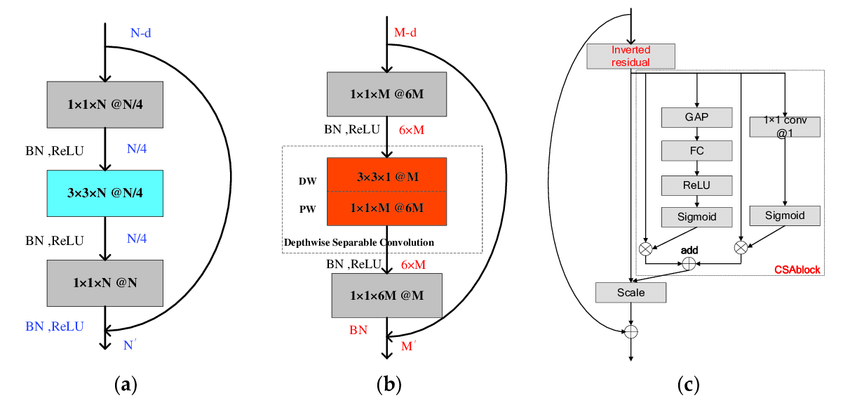


In [9]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

In [10]:
class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers

    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

## ResNet Model

In [11]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block

        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output


## ResNet with different layers

In [12]:
def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

## Image Classification on CIFAR10

### Configurations and Hyper-parameters

In [13]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
# Initialize a model, and put it on the device specified.
model = resnet18().to(device)

# The number of batch size.
batch_size = 64
# The number of training epochs.
n_epochs = 8
# If no improvement in 'patience' epochs, early stop.
patience = 5
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()
# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

### Load the data

In [14]:
# Data preprocessing for CIFAR-10 (normalizing based on CIFAR-10 mean and std)
transform = transforms.Compose([
    transforms.Resize(224),  # AlexNet was designed for 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
valid_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Training Function

In [16]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0
_exp_name = "sample"

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a9d69116290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a9d69116290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/782 [00:00<?, ?it/s]

[ Train | 001/008 ] loss = 1.13071, acc = 0.59711


  0%|          | 0/157 [00:00<?, ?it/s]

[ Valid | 001/008 ] loss = 1.16163, acc = 0.58997
[ Valid | 001/008 ] loss = 1.16163, acc = 0.58997 -> best
Best model found at epoch 0, saving model


  0%|          | 0/782 [00:00<?, ?it/s]

[ Train | 002/008 ] loss = 0.95448, acc = 0.66490


  0%|          | 0/157 [00:00<?, ?it/s]

[ Valid | 002/008 ] loss = 1.30602, acc = 0.56797
[ Valid | 002/008 ] loss = 1.30602, acc = 0.56797


  0%|          | 0/782 [00:00<?, ?it/s]

[ Train | 003/008 ] loss = 0.83192, acc = 0.70632


  0%|          | 0/157 [00:00<?, ?it/s]

[ Valid | 003/008 ] loss = 0.96336, acc = 0.66551
[ Valid | 003/008 ] loss = 0.96336, acc = 0.66551 -> best
Best model found at epoch 2, saving model


  0%|          | 0/782 [00:00<?, ?it/s]

[ Train | 004/008 ] loss = 0.73970, acc = 0.74107


  0%|          | 0/157 [00:00<?, ?it/s]

[ Valid | 004/008 ] loss = 0.89102, acc = 0.69676
[ Valid | 004/008 ] loss = 0.89102, acc = 0.69676 -> best
Best model found at epoch 3, saving model


  0%|          | 0/782 [00:00<?, ?it/s]

[ Train | 005/008 ] loss = 0.66729, acc = 0.76906


  0%|          | 0/157 [00:00<?, ?it/s]

[ Valid | 005/008 ] loss = 1.16291, acc = 0.64202
[ Valid | 005/008 ] loss = 1.16291, acc = 0.64202


  0%|          | 0/782 [00:00<?, ?it/s]

[ Train | 006/008 ] loss = 0.60172, acc = 0.79348


  0%|          | 0/157 [00:00<?, ?it/s]

[ Valid | 006/008 ] loss = 1.16829, acc = 0.62042
[ Valid | 006/008 ] loss = 1.16829, acc = 0.62042


  0%|          | 0/782 [00:00<?, ?it/s]

[ Train | 007/008 ] loss = 0.54691, acc = 0.81066


  0%|          | 0/157 [00:00<?, ?it/s]

[ Valid | 007/008 ] loss = 0.72396, acc = 0.75259
[ Valid | 007/008 ] loss = 0.72396, acc = 0.75259 -> best
Best model found at epoch 6, saving model


  0%|          | 0/782 [00:00<?, ?it/s]

[ Train | 008/008 ] loss = 0.50209, acc = 0.82653


  0%|          | 0/157 [00:00<?, ?it/s]

[ Valid | 008/008 ] loss = 0.80933, acc = 0.73398
[ Valid | 008/008 ] loss = 0.80933, acc = 0.73398
